In [11]:
from utils import (conv_15, load_dataset, train, plot_resuts, Controller, sns, plt)

# Notebook Start

In [5]:
dl_train, dl_dev, dl_test, X, y = load_dataset(dataset_name='moon', noise=0.01, rotate_angle=0)
controller = Controller()
num_rollouts = 50

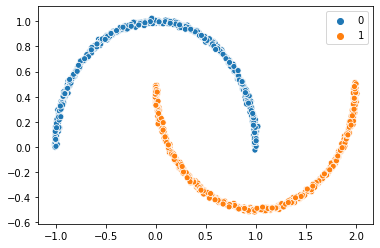

In [6]:
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y)

## Train conroller with low noise, and no Rotation

Training controller...


Done.


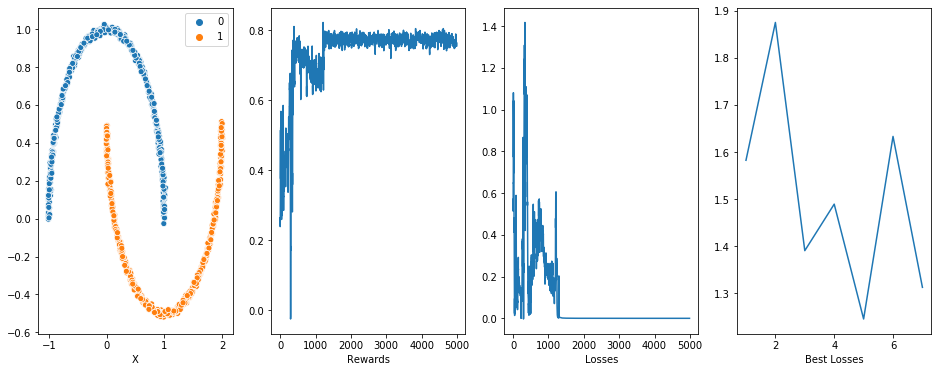

In [11]:
rewards, losses, saved_losses, best_child = train(controller, 5000, dl_train, dl_dev)
plot_resuts(X, y, rewards, losses, saved_losses)

In [12]:
best_child

Net(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Tanh()
    (2): Linear(in_features=8, out_features=1, bias=True)
    (3): Linear(in_features=1, out_features=2, bias=True)
  )
)

## Load trained controller, and Try it again on more complex dataset

In [35]:
dl_train, dl_dev, dl_test, X, y = load_dataset(dataset_name='moon', noise=0.1, rotate_angle=90)
transfer_controller = Controller()
# Load the controller
transfer_controller = load_controller(transfer_controller, path='moon_optimal_controller.pt')

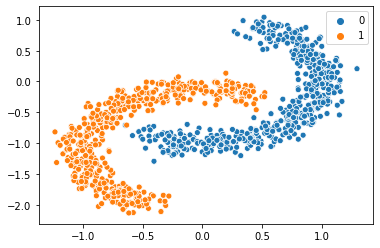

In [36]:
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y)

Training controller...


Done.


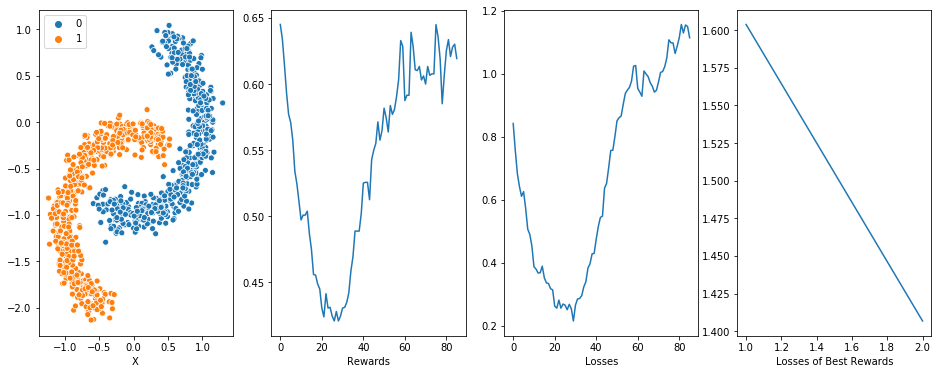

In [37]:
rewards, losses, saved_losses, best_child = train(transfer_controller, 100, dl_train, dl_dev, save=False)
plot_resuts(X, y, rewards, losses, saved_losses)

In [39]:
best_child

Net(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=4, out_features=8, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

In [42]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

net = best_child

losses = list()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2)

for epoch in range(250):  # loop over the dataset multiple times

    for i, data in enumerate(dl_train, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

print('Finished Training')

Finished Training


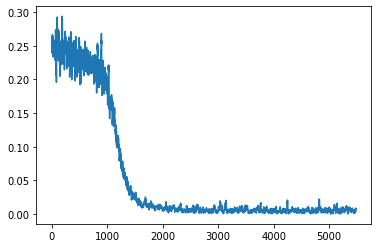

In [44]:
plt.plot(conv_15(losses))

## Train new controller on the same complex dataset

> if the new controller by chance choose that the optimal #of layers is 3 then it could achieve the transferred controller

Training controller...


Done.


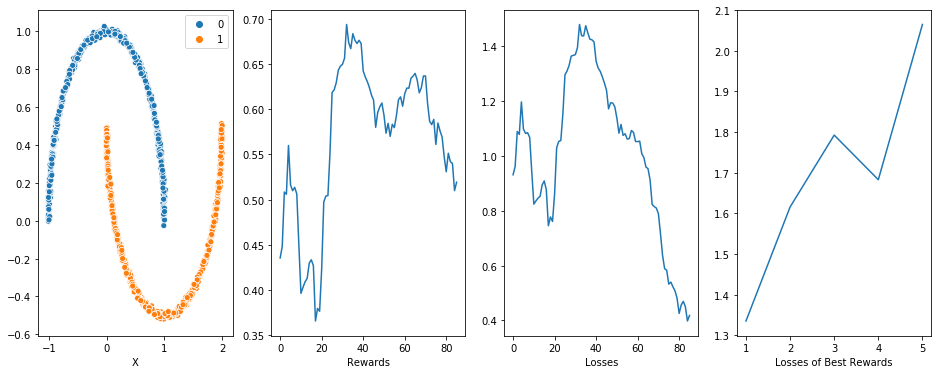

In [7]:
#del load_controller
new_controller = Controller()
rewards, losses, saved_losses, best_child = train(new_controller, 100, dl_train, dl_dev, save=False)
plot_resuts(X, y, rewards, losses, saved_losses)

In [8]:
best_child

Net(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=1, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=1, out_features=2, bias=True)
  )
)

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

net = best_child

losses = list()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2)

for epoch in range(250):  # loop over the dataset multiple times

    for i, data in enumerate(dl_train, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

print('Finished Training')

Finished Training


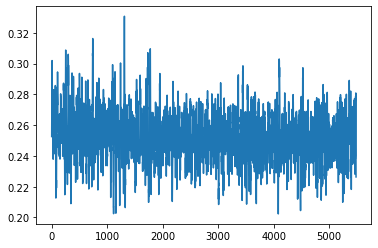

In [12]:
plt.plot(conv_15(losses))